In [96]:
#imports


import wfdb
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import os
import pandas as pd
from scipy.signal import butter, filtfilt
from biosppy.signals import ecg
from biosppy.signals import ppg
from biosppy.plotting import plot_ecg
from biosppy.plotting import plot_ppg

In [ ]:
#limpiar carpeta de archivos
def limpiar_carpeta(carpeta):
    for file in os.listdir(carpeta):
        os.remove(carpeta+'/'+file)
# limpiar_carpeta('data/dirty')
# limpiar_carpeta('data/cleaned')

In [ ]:
# Obtención de data en los archivos


def get_name_files(path,type):
    files = []
    for file in os.listdir(path):
        if file.endswith(type):
            files.append(file[:-4])
    return files

def read_file_hea(filename, path):
    # lee archivo .hea
    record = wfdb.rdheader(path+filename)
    return record

def read_file_mat(file, path):
    # carga archivo .mat (tiene las señales)
    mat_data = loadmat(path + file +'.mat')
    signals = mat_data['val']
    return signals

def read_file_flat(file,path):
    mat_data = loadmat(path + file +'.mat')
    if 'flatareas' in mat_data:
        flatareas = mat_data['flatareas']
    else:
        flatareas = np.array([])
    return flatareas

def read_file_zigzag(file,path):
    mat_data = loadmat(path + file +'.mat')
    if 'zigzagareas' in mat_data:
        zigzagareas = mat_data['zigzagareas']
    else:
        zigzagareas = np.array([])
    return zigzagareas

---

In [99]:
#Observación de metadata


# path de los archivos iniciales
old_path='data/training/'
#toma los nombres de los archivos .hea
nameFiles = get_name_files(old_path,'.hea')
#revisa el primer archivo .hea
heaRecord1 = read_file_hea(nameFiles[0], old_path)
print(heaRecord1.__dict__)

{'record_name': 'a103l', 'n_sig': 3, 'fs': 250, 'counter_freq': None, 'base_counter': None, 'sig_len': 82500, 'base_time': None, 'base_date': None, 'comments': ['Asystole', 'False alarm'], 'sig_name': ['II', 'V', 'PLETH'], 'p_signal': None, 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['a103l.mat', 'a103l.mat', 'a103l.mat'], 'fmt': ['16', '16', '16'], 'samps_per_frame': [1, 1, 1], 'skew': [None, None, None], 'byte_offset': [24, 24, 24], 'adc_gain': [7247.0, 10520.0, 12530.0], 'baseline': [0, 0, 0], 'units': ['mV', 'mV', 'NU'], 'adc_res': [16, 16, 16], 'adc_zero': [0, 0, 0], 'init_value': [-171, 9127, 6042], 'checksum': [-27403, -301, -17391], 'block_size': [0, 0, 0]}


In [100]:
all_unique_sig_names = set()
for file in nameFiles:
    record = read_file_hea(file, old_path)
    all_unique_sig_names.update(record.sig_name)

print(f"All unique signal names across all files: {all_unique_sig_names}")
print(f"Total number of unique signal names: {len(all_unique_sig_names)}")

All unique signal names across all files: {'aVR', 'V', 'III', 'PLETH', 'MCL', 'ABP', 'I', 'II', 'RESP', 'aVL', 'aVF'}
Total number of unique signal names: 11


In [ ]:
# contar cuantos datos .mat hay en data/training
i=0
for file in os.listdir('data/training/'):
    if file.endswith('.mat'):
        i += 1
print('cantidad de datos:', i)

cantidad de datos: 750


---
# Limpiar marcas de línea plana y zigzag

Si una señal tiene muchas marcas planas o zigzag, se deben tomar medidas:
- Si está en training, no se debe usar.
- Si esta en test, no se dispara ninguna alarma. y se etiqueta de alguna forma.


In [103]:
# funciones antiguas


def mark_flat_lines(signal, fs=250, min_duration=0.3, flat_value=-9999, threshold=7):
    """
    Marca líneas planas en la señal donde la diferencia entre valores consecutivos es menor que un umbral.

    Parameters:
    - signal: La señal a analizar (ECG o PPG).
    - fs: Frecuencia de muestreo en Hz.
    - min_duration: Duración mínima en segundos para que se considere una línea plana.
    - flat_value: El valor que se utilizará para marcar las líneas planas en la señal.
    - threshold: Umbral de diferencia entre muestras consecutivas para considerar una línea plana.
    
    Returns:
    - marked_signal: La señal con las líneas planas marcadas.
    - flat_areas: Lista de tuplas (inicio, fin) que indican las áreas planas detectadas.
    """
    # Número de muestras consecutivas que definen una línea plana
    min_samples = int(min_duration * fs)

    # Diferencias absolutas entre muestras consecutivas
    diff_signal = np.abs(np.diff(signal))

    # Encuentra dónde la diferencia es menor que el umbral
    flat_segments = (diff_signal < threshold).astype(int)

    # Identifica segmentos planos continuos de al menos min_samples de duración
    flat_areas = []
    current_length = 0
    start_index = None

    for i in range(len(flat_segments)):
        if flat_segments[i] == 1:  # Si es un segmento plano
            if current_length == 0:
                start_index = i
            current_length += 1
        else:
            if current_length >= min_samples:  # Si cumple con la duración mínima
                flat_areas.append((start_index, start_index + current_length))
            current_length = 0

    # Considerar el último segmento si termina en una zona plana
    if current_length >= min_samples:
        flat_areas.append((start_index, start_index + current_length))

    # Marca los segmentos planos en la señal
    marked_signal = np.copy(signal)
    for start, end in flat_areas:
        marked_signal[start:end] = flat_value  # Marcar con un valor específico como -9999
    
    return marked_signal, flat_areas

def mark_zigzag_lines(signal, fs=250, min_duration=0.3):
    """
    Identifica segmentos en zigzag en una señal.
    
    Parámetros:
    signal (numpy array): La señal a analizar.
    fs (int): Frecuencia de muestreo en Hz. Por defecto es 250 Hz.
    min_duration (float): Duración mínima en segundos de un zigzag. Por defecto es 0.2 segundos.
    
    Retorna:
    zigzag_areas (list): Lista de tuplas (inicio, fin) de los segmentos en zigzag.
    """
    # Número de muestras consecutivas que definen un zigzag
    min_samples = int(min_duration * fs)
    
    # Calcula las diferencias entre muestras consecutivas (pendiente)
    diff_signal = np.diff(signal)
    
    # Determina si la pendiente es positiva o negativa
    sign_changes = np.sign(diff_signal)
    
    # Identifica los cambios de signo consecutivos (zigzag)
    zigzag_segments = (sign_changes[:-1] * sign_changes[1:] == -1).astype(int)

    # Identifica segmentos zigzag continuos de al menos min_samples de duración
    zigzag_areas = []
    current_length = 0
    start_index = None
    
    for i in range(len(zigzag_segments)):
        if zigzag_segments[i] == 1:  # Cambio de pendiente
            if current_length == 0:
                start_index = i
            current_length += 1
        else:
            if current_length >= min_samples:
                zigzag_areas.append((start_index, start_index + current_length + 1))
            current_length = 0

    # Último segmento
    if current_length >= min_samples:
        zigzag_areas.append((start_index, start_index + current_length + 1))
    
    return zigzag_areas


---

# Limpieza de señales ECG y PLETH

In [ ]:

new_path = 'data/cleaned/'
dirty_path = 'data/dirty/'

if not os.path.exists(new_path):
    os.makedirs(new_path)

# Se limpian todas las señales, y se dejan en el nuevo directorio
for fileName in nameFiles:
    path = old_path
    record = read_file_hea(fileName, path)
    signals = read_file_mat(fileName, path)

    # Recorta y deja sólo los últimos 10 segundos de señal
    signals = signals[:, -record.fs*10:]
    dirtySignals = signals

    # Se aplica filtro sólo a las señales ECG ('I', 'II', 'III' y 'V') y PLETH
    ecg_type = ['I', 'II', 'III', 'V']
    pleth_type = ['PLETH']
    flat_areas_all = []
    zigzag_areas_all = []

    try:
        for i in range(len(record.sig_name)): 
            
            if record.sig_name[i] in ecg_type:
                flat_signal, flat_areas0 = mark_flat_lines(signals[i, :], fs=record.fs)
                zigzag_areas0 = mark_zigzag_lines(signals[i, :], fs=record.fs)
                flat_areas_all.append(flat_areas0)
                zigzag_areas_all.append(zigzag_areas0)
                channel = signals[i, :]
                channel = ecg.ecg(signal=channel, sampling_rate=250, show=False)

            elif record.sig_name[i] in pleth_type:
                flat_signal, flat_areas0 = mark_flat_lines(signals[i, :], fs=record.fs)
                zigzag_areas0 = mark_zigzag_lines(signals[i, :], fs=record.fs)
                flat_areas_all.append(flat_areas0)
                zigzag_areas_all.append(zigzag_areas0)
                channel = signals[i, :]
                channel = ppg.ppg(signal=channel, sampling_rate=250, show=False)

            else:
                flat_areas_all.append([])
                zigzag_areas_all.append([])

        # si no hay líneas planas ni zigzag en ningun canal, se guarda la señal
        if all(len(flat) == 0 for flat in flat_areas_all) and all(len(zigzag) == 0 for zigzag in zigzag_areas_all):
            # Guarda las señales sucias en un archivo .mat para ver cómo quedaron
            sio.savemat(dirty_path + fileName + '.mat', {'val': dirtySignals})
            # Guarda las señales limpias y las áreas en un archivo .mat
            sio.savemat(new_path + fileName + '.mat', {
            'val': signals,
            })
            print('flat areas:', flat_areas_all)
            print('zigzag areas: ', zigzag_areas_all)
            print('se guardó la señal ', fileName, ' en el directorio cleaned')
        else:
            raise Exception(f'Señal {fileName} contiene línes planas o zigzag'.format(fileName))

    except Exception as e:
        print(f'Señal corrupta {fileName}: {e}')
        print(f'Señal no califica para ser del training {fileName} se descarta todo su archivo')
        




flat areas: [[], [], []]
zigzag areas:  [[], [], []]
se guardó la señal  a103l  en el directorio cleaned
Error en señal a104s: Señal a104s contiene línes planas o zigzag
Señal no califica para ser del training a104s se descarta todo su archivo
flat areas: [[], [], []]
zigzag areas:  [[], [], []]
se guardó la señal  a105l  en el directorio cleaned
flat areas: [[], [], [], []]
zigzag areas:  [[], [], [], []]
se guardó la señal  a109l  en el directorio cleaned
Error en señal a123l: Not enough beats to compute heart rate.
Señal no califica para ser del training a123l se descarta todo su archivo
Error en señal a134s: Señal a134s contiene línes planas o zigzag
Señal no califica para ser del training a134s se descarta todo su archivo
Error en señal a142s: Señal a142s contiene línes planas o zigzag
Señal no califica para ser del training a142s se descarta todo su archivo
flat areas: [[], [], [], []]
zigzag areas:  [[], [], [], []]
se guardó la señal  a145l  en el directorio cleaned
Error en se

In [105]:
# Se revisa cuántas señales se guardaron en el directorio cleaned
i=0
for file in os.listdir('data/cleaned/'):
    if file.endswith('.mat'):
        i += 1
print('cantidad de datos válidos para training:', i)

cantidad de datos válidos para training: 750


---
 ## Visualizadores de señal

In [ ]:

def grafica_ecg(record, signals, path_save,picos_r=None):
    #grafica las señales ecg
    plt.figure(figsize=(12, 6))
    for i in range(len(record.sig_name)):
        plt.subplot(len(record.sig_name), 1, i+1)
        plt.plot(signals[i, :], label=f'Señal: {record.sig_name[i]}')
        if picos_r is not None:
            plt.plot(picos_r, signals[i, picos_r], 'ro', markersize=1)
            #Imprime los picos_r
            print(f'Picos R señal {record.sig_name[i]}: {picos_r}')

        plt.xlabel('Muestras')
        plt.ylabel(record.units[i])
        plt.legend()
    #agregar comentarios
    plt.suptitle(record.comments[0] + ' - ' + record.comments[1])
    # genera jpg
    plt.savefig(path_save + record.record_name + '.jpg')
    plt.close()

#función para graficar una cantidad de señales general y guardar en jpg
def graf_signals(files, path, cant, path_save):
    for fileName in files[:cant]:
        print('Graficando señales de: ', fileName)
        record = read_file_hea(fileName, 'data/training/')
        signals, flat_areas, zigzag_areas = read_file_mat(fileName, path) 
        #picos_r = sio.loadmat(path +file+'.mat')['picos_r']
        grafica_ecg(record,signals, path_save)

# Grafica todos los canales de una señal con sus areas planas y zigzag
def grafica_preview(record, signals, oldSignal, path, flat_areas=[], zigzag_areas=[]):
    oldSignal = oldSignal[:, -record.fs*10:]
    plt.figure(figsize=(12, 6))
    for i in range(signals.shape[0]):
        plt.subplot(signals.shape[0], 1, i + 1)
        plt.plot(signals[i, :], label=f'Señal limpia: {record.sig_name[i]}', color='blue', alpha=0.5)
        plt.plot(oldSignal[i, :], label=f'Señal original: {record.sig_name[i]}', color='red', alpha=0.3)
        # Resaltar visualmente los segmentos planos si existen

        if  flat_areas.size > 0:
            for flat in flat_areas[0,i]:
                plt.axvspan(flat[0], flat[1], color='red', alpha=0.5)

        # Resaltar visualmente los segmentos zigzag si existen
        if zigzag_areas.size > 0:
            for zigzag in zigzag_areas[0,i]:
                plt.axvspan(zigzag[0], zigzag[1], color='yellow', alpha=0.5)
        
        plt.xlabel('Muestras')
        plt.ylabel(record.units[i])
        plt.legend()

    plt.suptitle(record.comments[0] + ' - ' + record.comments[1])
    plt.show()

#Grafica señales de biosppy, limpias y con sus atributos importantes
def grafica_preview_bios(record, signal):
    try:
        ecg_type = ['I', 'II', 'III', 'V']
        pleth_type = ['PLETH']
        for i in range(len(record.sig_name)):
            channel = signal[i, :]
            if record.sig_name[i] in ecg_type:
                ecg.ecg(signal=channel, sampling_rate=250, show=True)
            elif record.sig_name[i] in pleth_type:
                ppg.ppg(signal=channel, sampling_rate=250, show=True)
    except Exception as e:
        print(f'Señal {record.record_name} no válida para esta gráfica: {e}')


In [130]:
# Visualizador general: Grafica toda la información útil de una señal
def visualizador_señales_en_file(nameFile_, path, old_path):
    nameFile = nameFiles.index(nameFile_) #nombre de la muestra
    record = read_file_hea(nameFiles[nameFile], old_path) #buscar . hea siempre será en old_path
    signalPreview = read_file_mat(nameFiles[nameFile], path)
    oldSignal = read_file_mat(nameFiles[nameFile], old_path)
    flat_areas = read_file_flat(nameFiles[nameFile], path)
    zigzag_areas = read_file_zigzag(nameFiles[nameFile], path)

    grafica_preview(record, signalPreview, oldSignal, path, flat_areas, zigzag_areas)
    grafica_preview_bios(record, signalPreview) #sólo para señales correctas
def visualizador_señales_limpias(record, signals):
    ecg_type = ['I', 'II', 'III', 'V']
    pleth_type = ['PLETH']
    print(record.comments[0] + ' - ' + record.comments[1])
    for i in range(len(record.sig_name)):
        print(record.sig_name[i])
        channel = signals[i, :]
        if record.sig_name[i] in ecg_type:
            ecg.ecg(signal=channel, sampling_rate=250, show=True)
        elif record.sig_name[i] in pleth_type:
            ppg.ppg(signal=channel, sampling_rate=250, show=True)


---
# División de los datos por anomalía

## Tabla de tipos de arritmia

| Tipo de Anomalía | Caracterísitica |
| --- | --- |
| Asistolia | Sin QRS durante al menos 4 segundos |
| Bradicardia extrema | Frecuencia cardíaca inferior a 40 lpm durante 5 latidos consecutivos |
| Taquicardia extrema | Frecuencia cardíaca superior a 140 lpm durante 17 latidos consecutivos |
| Taquicardia ventricular | 5 o más latidos ventriculares con frecuencia cardíaca superior a 100 lpm |
| Aleteo ventricular/Fibrilación | Fibrilatoria, aleteo o forma de onda oscilatoria durante al menos 4 segundos |

In [ ]:

new_path = 'data/cleaned/'
#toma los nombres de los archivos .hea
nameFiles = get_name_files(new_path,'.mat')
#revisa el primer archivo .hea
#heaRecord1 = read_file_hea(nameFiles[0], old_path)
#print(heaRecord1.__dict__)

all_unique_comments_anomaly = set()
for file in nameFiles:
    record = read_file_hea(file, old_path)
    all_unique_comments_anomaly.update(record.comments[0].split())

print(f"All unique signal names across all files: {all_unique_comments_anomaly}")
print(f"Total number of unique signal names: {len(all_unique_comments_anomaly)}")

# Dividir por anomalías

# Define el directorio base para guardar los datos
base_dir = 'data/cleaned_by_anomaly/'

# crear el directorio para cada anomalía
for anomaly in all_unique_comments_anomaly:
    anomaly_path = os.path.join(base_dir, anomaly)
    if not os.path.exists(anomaly_path):
        os.makedirs(anomaly_path)

# en casi de buscar hacerlo por anomalía

# asystole = []
# bradycardia = []
# tachycardia = []
# ventricular_tachycardia = []
# ventricular_flutter_fib = []


# for fileName in nameFiles:
#     signals = read_file_mat(fileName, new_path)
#     record = read_file_hea(fileName, old_path)

#     if record.comments[0] == 'Asystole':
#         #sio.savemat(base_dir + 'Asystole/' + fileName + '.mat', {'val': signals})
#         asystole.append({'signals': signals, 'record': record, 'fileName':fileName})
#     elif record.comments[0] == 'Bradycardia':
#         # sio.savemat(base_dir + 'Bradycardia/' + fileName + '.mat', {'val': signals})
#         bradycardia.append({'signals': signals, 'record': record, 'fileName':fileName})
#     elif record.comments[0] ==  'Tachycardia':
#         # sio.savemat(base_dir + 'Tachycardia/' + fileName + '.mat', {'val': signals})
#         tachycardia.append({'signals': signals, 'record': record, 'fileName':fileName})
#     elif record.comments[0] == 'Ventricular_Tachycardia':
#         # sio.savemat(base_dir + 'Ventricular_Tachycardia/' + fileName + '.mat', {'val': signals})
#         ventricular_tachycardia.append({'signals': signals, 'record': record, 'fileName':fileName})
#     elif record.comments[0] == 'Ventricular_Flutter_Fib':
#         # sio.savemat(base_dir + 'Ventricular_Flutter_Fib/' + fileName + '.mat', {'val': signals})
#         ventricular_flutter_fib.append({'signals': signals, 'record': record, 'fileName':fileName})
#     else:
#         print(f'Anomalía desconocida en señal {fileName}: {record.comments[0]}')

        

All unique signal names across all files: {'Tachycardia', 'Bradycardia', 'Ventricular_Tachycardia', 'Asystole', 'Ventricular_Flutter_Fib'}
Total number of unique signal names: 5


---

# Verificando señales

In [ ]:
#print(bradycardia[0])

{'signals': array([[-296, -341, -366, ..., -439, -432, -431],
       [  95,   52,   13, ...,  914, 1009, 1062],
       [-137, -161, -184, ..., 1630, 1627, 1615]], dtype=int16), 'record': <wfdb.io.record.Record object at 0x00000168959CD940>, 'fileName': 'b124s'}


Bradycardia - True alarm
II


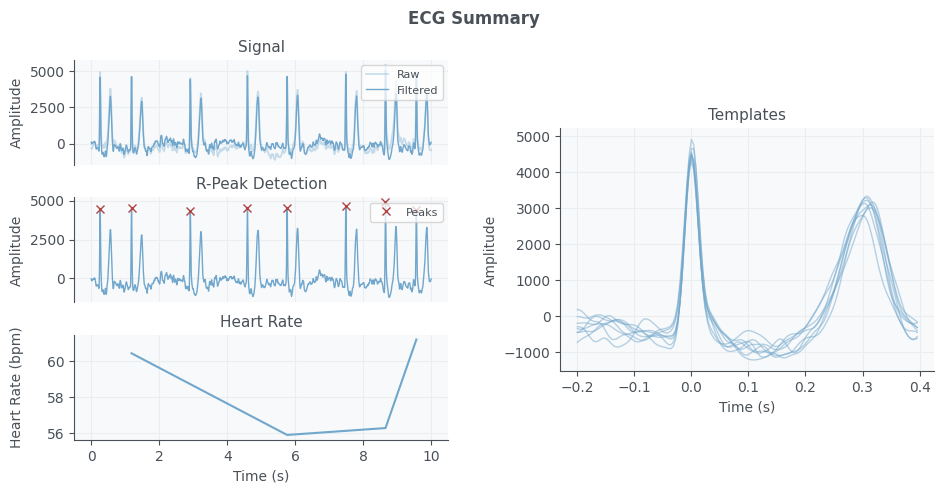

V


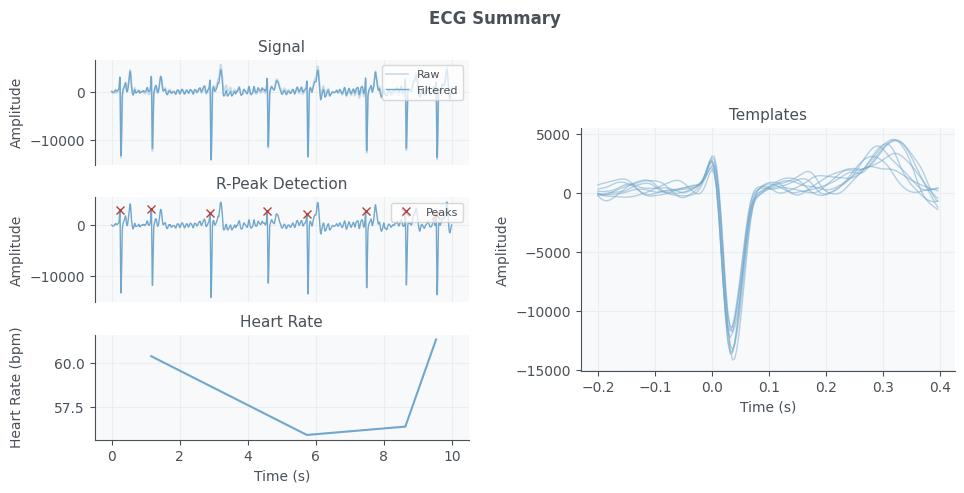

PLETH


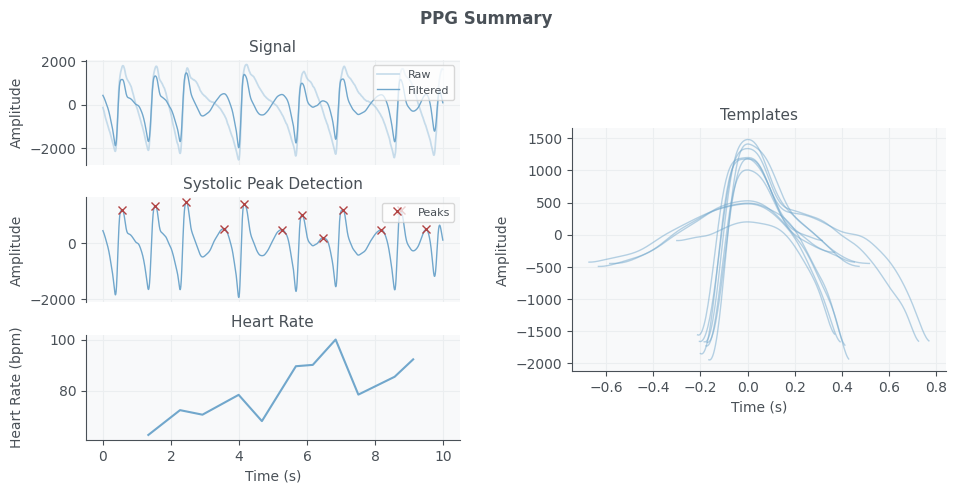

In [ ]:
# path=base_dir + 'Bradycardia/'
# visualizador_señales_en_file('b125l', path, old_path)

#visualizador_señales_limpias(bradycardia[0]['record'], bradycardia[0]['signals'])


---

# Detección por anomalía

Pasos a seguir:
1. Detectada la anomalía relacionada
1.1 ventana de caracterísitcas
2. Observar equilibrio entre datos de entrenamiento y de testeo
3. Dividir datos de entrenamiento y de testeo
4. Desarrollar algoritmo de entrenamiento
5. calificar algoritmo de entrenamiento

### Para autoencoder

In [ ]:
from sklearn.model_selection import train_test_split

for fileName in os.listdir('data/cleaned/'):
    if file.endswith('.mat'):
        signal = read_file_mat(fileName, new_path)
        record = read_file_hea(fileName, old_path)
        

# Supón que tienes tus señales y etiquetas organizadas en listas o arrays
signals = 

labels = []       # etiquetas de anomalía

# Divide en entrenamiento (80%) y prueba (20%), estratificando por etiquetas de anomalía
signals_train, signals_test, labels_train, labels_test = train_test_split(
    signals, labels, test_size=0.2, stratify=labels, random_state=42
)